<a href="https://colab.research.google.com/github/aamernabi/classifications/blob/master/flower_classification/Flower_Classification_using_Pre_Trained_Model_(Efficientnet_lite4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classification using Pre-Trained Model (Efficientnet-lite4)

In [27]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# tensorflow imports 
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense

In [29]:
print("tensorflow version: {}".format(tf.__version__))

tensorflow version: 2.2.0


## Download the Flower using TensorFlow Dataset

In [30]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]']
)

### Print Information about the Flowers Dataset 

In [31]:
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

num_train_examples = 0
num_val_examples = 0

for example in training_set:
  num_train_examples += 1
  
for example in validation_set:
  num_val_examples += 1

print('No. of classes: {}'.format(num_classes))
print('No. of examples: {}'.format(num_examples))
print('No. of validation examples: {}'.format(num_train_examples))
print('No. of validation examples: {}'.format(num_val_examples))

No. of classes: 5
No. of examples: 3670
No. of validation examples: 2569
No. of validation examples: 1101


The dataset we downloaded contains images of 5 types of flowers:

    Rose
    Daisy
    Dandelion
    Sunflowers
    Tulips


In [32]:
# images are not of same size
for i, examples in enumerate(training_set.take(5)):
  print('Image {} shape: {}, label: {}'.format(i + 1, examples[0].shape, examples[1]))

Image 1 shape: (333, 500, 3), label: 2
Image 2 shape: (212, 320, 3), label: 3
Image 3 shape: (240, 320, 3), label: 3
Image 4 shape: (240, 320, 3), label: 4
Image 5 shape: (317, 500, 3), label: 3


##  Reformat Images

In [33]:
IMAGE_RES = 224

def reformat(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

In [34]:
BATCH_SIZE = 32

train_batches = training_set.shuffle(num_train_examples//4).map(reformat).batch(BATCH_SIZE).prefetch(1) 
val_batches = validation_set.map(reformat).batch(BATCH_SIZE).prefetch(1)

## Transfer Learning with TensorFlow Hub

In [35]:
#URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
URL = "https://tfhub.dev/tensorflow/efficientnet/lite4/classification/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

**Freeze** the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [36]:
feature_extractor.trainable = False

### Attach a classification head

In [37]:
model = tf.keras.Sequential([
    feature_extractor,
    Dense(num_classes, activation='softmax')
])

Summary of model

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1000)              13118936  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5005      
Total params: 13,123,941
Trainable params: 5,005
Non-trainable params: 13,118,936
_________________________________________________________________


### Train the model

In [39]:
#epochs = 6
epochs = 4

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_batches,
    epochs=epochs, 
    validation_data=val_batches
)

Epoch 1/4
81/81 [==============================] - 24s 295ms/step - loss: 1.2017 - accuracy: 0.7057 - val_loss: 1.0848 - val_accuracy: 0.8265
Epoch 2/4
81/81 [==============================] - 23s 285ms/step - loss: 1.0503 - accuracy: 0.8669 - val_loss: 1.0599 - val_accuracy: 0.8538
Epoch 3/4
81/81 [==============================] - 23s 288ms/step - loss: 1.0256 - accuracy: 0.8883 - val_loss: 1.0425 - val_accuracy: 0.8629
Epoch 4/4
81/81 [==============================] - 23s 288ms/step - loss: 1.0098 - accuracy: 0.9070 - val_loss: 1.0389 - val_accuracy: 0.8701


~88% validation accuracy with only 6 epochs of training, which is absolutely awesome. 

## Plot Training and Validation Graphs.

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


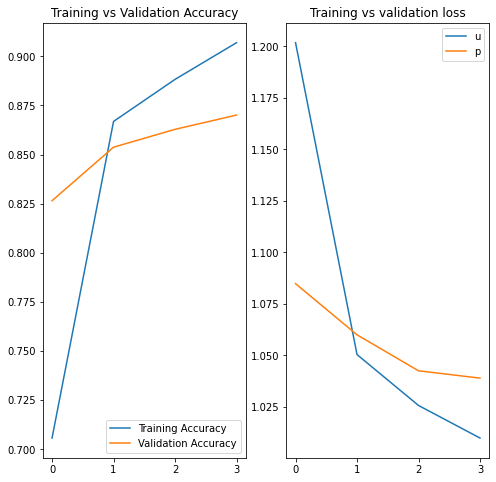

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend('upper right')
plt.title('Training vs validation loss')

plt.show()


## Check Predictions

In [43]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Create an Image Batch and Make Predictions

In [44]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

In [45]:
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_classes = class_names[predicted_ids]

print(predicted_classes)

['roses' 'daisy' 'daisy' 'dandelion' 'dandelion' 'roses' 'dandelion'
 'sunflowers' 'tulips' 'sunflowers' 'sunflowers' 'roses' 'daisy'
 'dandelion' 'sunflowers' 'roses' 'dandelion' 'roses' 'daisy' 'dandelion'
 'tulips' 'roses' 'tulips' 'daisy' 'sunflowers' 'tulips' 'daisy'
 'dandelion' 'sunflowers' 'sunflowers' 'dandelion' 'daisy']


## Plot Model Predictions

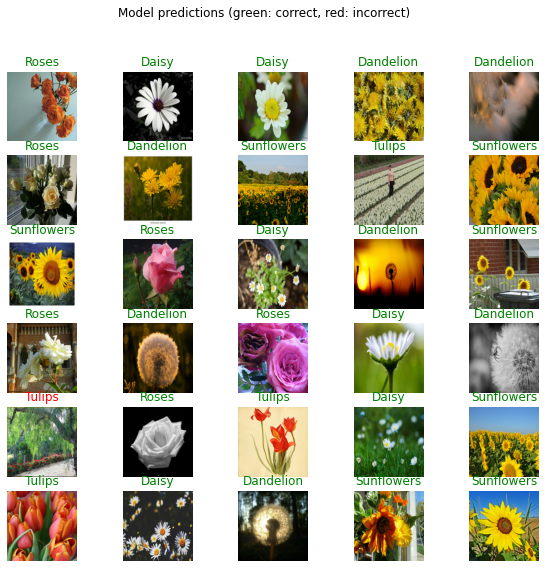

In [47]:
plt.figure(figsize=(10, 9))

for n in range(30):
  plt.subplot(6, 5, n + 1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_classes[n].title(), color= color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')
  